In [25]:
import os
os.getcwd() 

'/home/yz685'

In [55]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')

import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor

from test_problems.synthetic_problem import generate_principal_axes, PCATestProblem
from src.transforms import (
    generate_random_projection,
    InputCenter,
    LinearProjectionInputTransform,
    LinearProjectionOutcomeTransform,
    PCAInputTransform,
    PCAOutcomeTransform,
    SubsetOutcomeTransform,
)
from src.pref_learning_helpers import gen_initial_real_data, fit_pref_model
from src.diagnostics import check_util_model_fit

# import botorch, gpytorch functions
from botorch import fit_gpytorch_model
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.optim.utils import _filter_kwargs
from botorch.utils.sampling import draw_sobol_samples
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import ChainedOutcomeTransform, Standardize
from botorch.models.transforms.input import (
    ChainedInputTransform,
    FilterFeatures,
    Normalize,
)

from gpytorch.kernels import MaternKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Overview

In this notebook, we generate synthetic metric data and test two modeling approaches, namely

- [baseline] fit a single-task GP to each metric
- [proposed] perform PCA on the metric data, and fit single-task GPs to the principal components (PCs)

## TL;DR: 
We use a toy example to show that using all the principal axes (same number as output space dimension) achieves a better model fit than fitting independent single-task GPs.

(Next steps would be to increase the dimensionality and use fewer principal axes.)

As a toy example, we work with a one-dimensional input space [0, 1] and two-dimensional output space (i.e., metric space). We fix two ground-truth principal axes and generate scalar PC values from two single-task GPs with different lengthscales, so that the first principal axis is more dominant.

In [4]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [28]:
config = {
    "input_dim": 1,
    "outcome_dim": 2,
    "latent_dim": 2,
    "PC_noise_level": 0,
    "noise_std": 0.2,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([[0.707, 0.707], [-0.707, 0.707]]),
    "PC_lengthscales": [0.1, 0.5],
    "PC_scaling_factors": [2, 1],
    "variance_explained_threshold": 0.99,
}

torch.manual_seed(1234)

full_axes = generate_principal_axes(
    output_dim=config["outcome_dim"], num_axes=config["outcome_dim"], **tkwargs
)

ground_truth_principal_axes = full_axes[: config["latent_dim"]]
initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

In [30]:
torch.manual_seed(123)

train_X = (
    draw_sobol_samples(bounds=problem.bounds, n=1, q=20)
    .squeeze(0)
    .to(torch.double)
)

train_Y = problem.eval_metrics_noisy(train_X).detach()
train_Y = train_Y - torch.mean(train_Y, dim = 0)

In [31]:
st_model = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll = ExactMarginalLogLikelihood(st_model.likelihood, st_model)
fit_gpytorch_model(st_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [32]:
options = {"maxiter": 1000}

pca_model = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(2, min_stdv=10),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll = ExactMarginalLogLikelihood(pca_model.likelihood, pca_model)

# train PCA model and log training stats
# fit_gpytorch_scipy(pca_mll, options=options)
fit_gpytorch_model(pca_mll)

/home/yz685/low_rank_BOPE/low_rank_BOPE/src/transforms.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.axes_learned = torch.tensor(axes_learned, **tkwargs)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): ChainedOutcomeTransform(
      (standardize): Standardize()
      (pca): PCAOutcomeTransform()
    )
  )
)

In [33]:
axes_learned_tensor = pca_model.outcome_transform['pca'].axes_learned
# axes_learned_tensor = pca_model.outcome_transform.axes_learned
axes_learned_tensor

tensor([[-0.6400, -0.7684]], dtype=torch.float64)

In [34]:
axes_learned = axes_learned_tensor.detach().numpy()

In [35]:
pca_model.outcome_transform["pca"].__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'variance_explained_threshold': 0.9,
 'num_axes': 1,
 'PCA_explained_variance': tensor(0.9659, dtype=torch.float64),
 'axes_learned': tensor([[-0.6400, -0.7684]], dtype=torch.float64)}

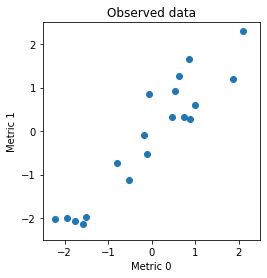

In [36]:
# plot the observed metric data, the ground truth principal axes, and the learned principal axes

plt.scatter(train_Y.numpy()[:, 0], train_Y.numpy()[:, 1])
plt.title("Observed data")
plt.xlabel("Metric 0")
plt.ylabel("Metric 1")
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.gca().set_aspect("equal")

plt.savefig('WPnote_2Dproblem_PCAplot_noaxis.png')

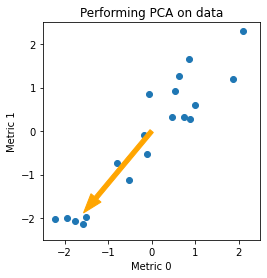

In [37]:
# plot the observed metric data, the ground truth principal axes, and the learned principal axes

plt.scatter(train_Y.numpy()[:, 0], train_Y.numpy()[:, 1])
plt.title("Performing PCA on data")
plt.xlabel("Metric 0")
plt.ylabel("Metric 1")
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.gca().set_aspect("equal")

# axes = kwargs["ground_truth_principal_axes"]

# true_axis_0 = plt.arrow(x=0, y=0, dx=2 * axes_learned[0, 0], dy=2 * axes[0, 1], width=0.1, color="blue")
# true_axis_1 = plt.arrow(x=0, y=0, dx=axes[1, 0] / 5, dy=axes[1, 1] / 5, width=0.02, color="blue")

learned_axis_0 = plt.arrow(x=0, y=0, dx=2 * axes_learned[0, 0], dy=2 * axes_learned[0, 1], width=0.1, color="orange")

# plt.legend([true_axis_0, learned_axis_0], ["true axis", "learned axis"])
# plt.savefig("2Dexample.png", dpi=1200, bbox_inches='tight')

plt.savefig('WPnote_2Dproblem_PCAplot.png')

In [38]:
PC_learned = torch.matmul(train_Y, torch.transpose(axes_learned_tensor, 0, 1))

In [39]:
model_pc = SingleTaskGP(
    train_X, PC_learned,
    # covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
    )
pc_mll = ExactMarginalLogLikelihood(pca_model.likelihood, model_pc)

fit_gpytorch_model(pc_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

torch.Size([101]) torch.Size([101])


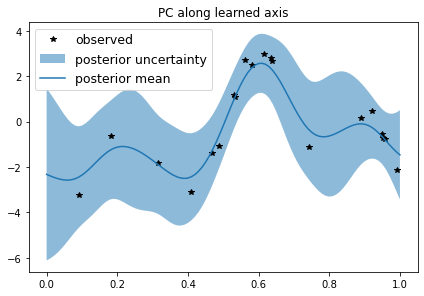

In [40]:
plt.plot(
    train_X.detach().numpy(), PC_learned.detach().numpy()[:, 0], "k*", label="observed"
)

plt.tight_layout()
plt.title("PC along learned axis")

num_test_points = 101
test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)
test_PC_posterior_mean = model_pc.posterior(test_X).mean.squeeze(1)
test_PC_posterior_var = model_pc.posterior(test_X).variance.squeeze(1)
print(test_PC_posterior_mean.shape, test_PC_posterior_var.shape)
lower = test_PC_posterior_mean - 1.96 * torch.sqrt(test_PC_posterior_var)
upper = test_PC_posterior_mean + 1.96 * torch.sqrt(test_PC_posterior_var)

plt.fill_between(
    test_X.squeeze(1),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.5,
    label="posterior uncertainty",
)

plt.plot(test_X, test_PC_posterior_mean.detach().numpy(), label="posterior mean")

plt.legend(fontsize=12.5)

plt.savefig('WPnote_2Dproblem_GPonPC.png', bbox_inches='tight')

In [54]:
def plotting_helper(num_test_points, models_dict, outcome_idxs):

    f, axs = plt.subplots(1, len(outcome_idxs), figsize = (12,4))

    test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)

    test_Y = problem.eval_metrics_true(test_X).detach()

    # test_Y = problem.evaluate_true(test_X).detach()[:, outcome_idx]
    # plt.scatter(test_X, test_Y)

    for outcome_idx in outcome_idxs:

        axs[outcome_idx].plot(train_X, train_Y[:, outcome_idx].detach().numpy(), 'k*', label = 'observed')

        for model_name, model in models_dict.items():

            test_Y_posterior_mean = model.posterior(test_X).mean[:, outcome_idx]
            test_Y_posterior_var = model.posterior(test_X).variance[:, outcome_idx]
            lower = test_Y_posterior_mean - 1.96 * torch.sqrt(test_Y_posterior_var)
            upper = test_Y_posterior_mean + 1.96 * torch.sqrt(test_Y_posterior_var)

            axs[outcome_idx].fill_between(
                test_X.squeeze(1),
                lower.detach().numpy(),
                upper.detach().numpy(),
                alpha=0.5,
                label = model_name + ' posterior uncertainty'
            )

            axs[outcome_idx].set_title(f"{model_name} fitted outcome {outcome_idx}")

            axs[outcome_idx].plot(test_X, test_Y_posterior_mean.detach().numpy(), label = model_name + ' posterior mean')

            print(model_name, 'outcome', outcome_idx, 'RMSE', torch.sqrt(torch.mean(torch.square(test_Y_posterior_mean - test_Y[:,outcome_idx]))).item())

            axs[outcome_idx].legend(fontsize = 12.5)

PCA outcome 0 RMSE 1.276985429538041
Indep outcome 0 RMSE 1.1402821112574273
PCA outcome 1 RMSE 1.4581521452190997
Indep outcome 1 RMSE 1.4772723801865295


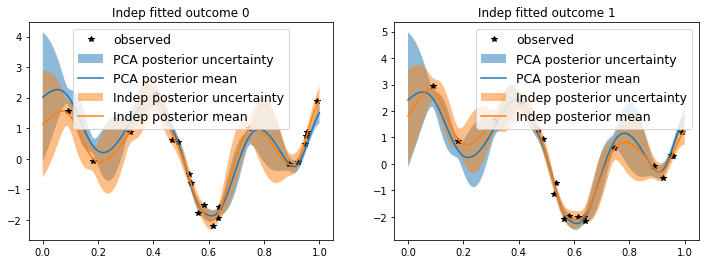

In [55]:
plotting_helper(101, {"PCA": pca_model, "Indep": st_model}, [0,1])

In [343]:
# next: 

# Now what if we dramatically increase the outcome dimensionality?

In [31]:
config = {
    "input_dim": 1,
    "outcome_dim": 100,
    "latent_dim": 1,
    "PC_noise_level": 0,
    "noise_std": 0.1,
    "num_initial_samples": 20,
    "num_sample_points": 30,
    "jitter": 0.00001,  # noqa
    "ground_truth_principal_axes": torch.Tensor([1]*10),
    "PC_lengthscales": [0.1],
    "PC_scaling_factors": [2],
    "variance_explained_threshold": 0.99,
}

torch.manual_seed(1234)

full_axes = generate_principal_axes(
    output_dim=config["outcome_dim"], num_axes=config["outcome_dim"], **tkwargs
)

ground_truth_principal_axes = full_axes[: config["latent_dim"]]
initial_X = torch.randn((config["num_initial_samples"], config["input_dim"]), **tkwargs)

obj_indices = list(range(config["outcome_dim"]))
cons_indices = []

problem = PCATestProblem(
    opt_config=(obj_indices, cons_indices),
    initial_X=initial_X,
    bounds=torch.Tensor([[0, 1]] * config["input_dim"]),
    ground_truth_principal_axes=ground_truth_principal_axes,
    noise_std=config["noise_std"],
    PC_lengthscales=Tensor(config["PC_lengthscales"]),
    PC_scaling_factors=Tensor(config["PC_scaling_factors"]),
    dtype=torch.double,
)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/test_functions/base.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "bounds", torch.tensor(self._bounds, dtype=torch.float).transpose(-1, -2)


In [ ]:
class LinearUtil(torch.nn.Module):
    def __init__(self, beta: torch.Tensor):
        """
        Args:
            beta: size `output_dim` tensor
        """
        super().__init__()
        self.register_buffer("beta", beta)

    def calc_raw_util_per_dim(self, Y):
        return Y * self.beta.to(Y)

    def forward(self, Y, X=None):
        return Y @ self.beta.to(Y)

class SumOfSquaresUtil(torch.nn.Module):
    def __init__(self, beta: torch.Tensor):
        """
        Args:
            beta: size `output_dim` tensor
        """
        super().__init__()
        self.register_buffer("beta", beta)

    def calc_raw_util_per_dim(self, Y):
        return torch.square(Y) * self.beta.to(Y)

    def forward(self, Y, X=None):
        return torch.square(Y) @ self.beta.to(Y)

In [70]:
torch.manual_seed(123)

beta = torch.tensor([1]*config["outcome_dim"], **tkwargs)
util_func = LinearUtil(beta=beta)

train_X, train_Y, util_vals, comps = gen_initial_real_data(n=500, problem=problem, util_func=util_func)

train_Y = train_Y - torch.mean(train_Y, dim = 0)

cpu_util:  tensor([  8.8405, -47.0874,  13.8411,   2.3938, -12.2367, -46.5487, -32.0722,
        -15.0541, -10.4919, -29.3281,  -3.2722, -50.4584, -45.0175, -14.2227,
          5.0210, -22.7531, -13.7664,  -9.5589, -23.6141, -41.1398, -11.3455,
          9.0708, -14.2181, -38.7104, -46.1956,  10.5820,  -6.9344,  -6.5360,
        -30.6586,  16.3167,   6.9649,  -8.9703, -12.9297,   0.9644, -11.8601,
        -29.5274, -22.0319,  15.2497, -13.1416, -16.7854,   9.5891,   0.8459,
        -16.4236, -36.3541,  -6.4404,   1.0367,   0.8677,  -3.3831,  -2.4553,
         13.1929,  10.7177,   2.5714,  -1.5748, -37.9812, -47.9773,  12.5232,
          3.4801,   6.8846,   0.7529,  13.3296, -17.4609, -11.3442,  -2.1596,
          6.7206,  -4.3841,   5.0055,  -1.8898,  -0.9081, -15.8014,  -8.5740,
        -11.2187, -31.1599, -11.0848,  14.1949,  -7.0769,  -4.6241, -20.3324,
        -28.2809,   7.1881, -24.1505,  -5.3535,  11.5138, -15.4206, -23.3892,
         -3.3394, -15.7985,  12.4583,  12.3157,  12.2

In [60]:
train_X.shape, train_Y.shape

(torch.Size([1000, 1]), torch.Size([1000, 100]))

In [71]:
st_model = SingleTaskGP(
    train_X,
    train_Y,
    covar_module = MaternKernel(lengthscale_prior = GammaPrior(3,6))
)
st_mll = ExactMarginalLogLikelihood(st_model.likelihood, st_model)
fit_gpytorch_model(st_mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [72]:
options = {"maxiter": 1000}

pca_model = SingleTaskGP(
    train_X,
    train_Y,
    outcome_transform=ChainedOutcomeTransform(
        **{
            "standardize": Standardize(config["outcome_dim"], min_stdv=10),
            "pca": PCAOutcomeTransform(num_axes=1),
        }
    ),
    likelihood=GaussianLikelihood(noise_prior=GammaPrior(0.9, 10)),
)
pca_mll = ExactMarginalLogLikelihood(pca_model.likelihood, pca_model)

# train PCA model and log training stats
# fit_gpytorch_scipy(pca_mll, options=options)
fit_gpytorch_model(pca_mll)

print(pca_model.outcome_transform['pca'].axes_learned)

/home/yz685/low_rank_BOPE/low_rank_BOPE/src/transforms.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.axes_learned = torch.tensor(axes_learned, **tkwargs)


tensor([[-0.0961, -0.0901, -0.1028, -0.0996, -0.0979, -0.0946, -0.1057, -0.1017,
         -0.0986, -0.0928, -0.0964, -0.1197, -0.0977, -0.1037, -0.1065, -0.0954,
         -0.0962, -0.0998, -0.0878, -0.0970, -0.0970, -0.1079, -0.1047, -0.1031,
         -0.0976, -0.0941, -0.0967, -0.0976, -0.1000, -0.0909, -0.0966, -0.1051,
         -0.0865, -0.0870, -0.1084, -0.1023, -0.0901, -0.0955, -0.1103, -0.1015,
         -0.0864, -0.0950, -0.1082, -0.1062, -0.1014, -0.1060, -0.1010, -0.0989,
         -0.1025, -0.0962, -0.1110, -0.1025, -0.0975, -0.0947, -0.0951, -0.0991,
         -0.1043, -0.1052, -0.1065, -0.0961, -0.1042, -0.1024, -0.0981, -0.0910,
         -0.1060, -0.0970, -0.1006, -0.0900, -0.0934, -0.0944, -0.0840, -0.0966,
         -0.0975, -0.1051, -0.0961, -0.0907, -0.1131, -0.1125, -0.1015, -0.0990,
         -0.1029, -0.0983, -0.0979, -0.1039, -0.0969, -0.1135, -0.1007, -0.1065,
         -0.1104, -0.0981, -0.0938, -0.1038, -0.0909, -0.0983, -0.1029, -0.1072,
         -0.0990, -0.0994, -

In [73]:
def helper(num_test_points, models_dict, outcome_idxs):

    test_X = torch.linspace(0, 1, num_test_points).unsqueeze(1).to(**tkwargs)
    test_Y = problem.eval_metrics_true(test_X).detach()

    for outcome_idx in outcome_idxs:

        for model_name, model in models_dict.items():

            test_Y_posterior_mean = model.posterior(test_X).mean[:, outcome_idx]
           
            print(model_name, 'outcome', outcome_idx, 'RMSE', torch.sqrt(torch.mean(torch.square(test_Y_posterior_mean - test_Y[:,outcome_idx]))).item())



In [74]:
helper(101, {"PCA": pca_model, "Indep": st_model}, [0,1,2,3,4,5,6,7,8,9])

PCA outcome 0 RMSE 0.09595269922582655
Indep outcome 0 RMSE 0.09834512677346323
PCA outcome 1 RMSE 0.09097334014327801
Indep outcome 1 RMSE 0.09385855882761768
PCA outcome 2 RMSE 0.10250827851238759
Indep outcome 2 RMSE 0.10467668184643986
PCA outcome 3 RMSE 0.09340311194061335
Indep outcome 3 RMSE 0.0949434013900174
PCA outcome 4 RMSE 0.09078005430368156
Indep outcome 4 RMSE 0.09412353235892026
PCA outcome 5 RMSE 0.09001335498601817
Indep outcome 5 RMSE 0.09160182800713851
PCA outcome 6 RMSE 0.09992820226422167
Indep outcome 6 RMSE 0.10070221280475633
PCA outcome 7 RMSE 0.09512531465439586
Indep outcome 7 RMSE 0.09575422891744112
PCA outcome 8 RMSE 0.09762762509114913
Indep outcome 8 RMSE 0.09915567531555854
PCA outcome 9 RMSE 0.09041020556836192
Indep outcome 9 RMSE 0.09180555437275635


In [75]:
pca_util_model = fit_pref_model(
    train_Y, 
    comps, 
    input_transform=ChainedInputTransform(
                    **{
                        "center": InputCenter(config["outcome_dim"]),
                        "pca": PCAInputTransform(pca_model.outcome_transform['pca'].axes_learned),
                    }
                )
)

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-

In [76]:
st_util_model = fit_pref_model(
    train_Y, 
    comps, 
    input_transform=Normalize(config["outcome_dim"])
)

In [77]:
check_util_model_fit(
    pref_model = pca_util_model,
    problem=problem,
    util_func=util_func,
    n_test=100,
    batch_eval=True
)

cpu_util:  tensor([-42.9160, -20.5004, -47.1178, -13.0499,  -8.9206, -22.5859,  -8.6466,
        -48.2201,  13.1346, -47.8401,   8.6471, -17.5685,  -9.9922,  15.7255,
         -4.9202, -34.4147, -20.4536, -49.1054, -13.5302,  12.9875, -16.5645,
        -11.4971,  11.8476, -25.7091, -11.8361,  -7.4527,  -2.2619, -49.4666,
         12.3036,  -4.4593,  12.6315,  10.7420,  -1.9001, -17.3925, -17.3482,
        -24.2558,  -6.2007,  -6.0639, -25.8441,   0.8080, -10.3032,  14.1056,
        -14.1131,  12.0953,  13.2833, -49.8339, -16.7921,  -8.9109, -13.0689,
         14.0861,  -4.0047,   7.8778, -14.6792, -46.5957, -26.2048,   0.8186,
         12.3784,   0.7318,  11.7860,  -2.4110,   0.0852,  13.6585,  15.6366,
        -13.1607, -13.1242,  11.7255, -25.9737,  -6.9077,  -8.7163,  10.3967,
         -5.9289, -12.0813,  -6.5158,  -8.0626, -19.3711,  15.0311,  11.5157,
        -21.9701, -11.0567,  -4.8365, -21.1009,  -7.7504, -27.2581,  -2.0812,
        -37.4342, -31.5250,  -8.0958,   9.9973,  -2.0

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


0.7599999904632568

In [78]:
check_util_model_fit(
    pref_model = st_util_model,
    problem=problem,
    util_func=util_func,
    n_test=100,
    batch_eval=True
)

cpu_util:  tensor([ 2.4877e+00, -3.1806e+01, -4.8423e+01, -1.1004e+01, -4.2928e+01,
        -4.7675e+00,  4.9332e+00, -1.2365e+01, -1.8423e+01, -2.1510e+01,
        -4.5860e+01, -1.5289e+01, -1.2706e+01, -4.9001e+01,  1.4645e+01,
         1.4199e+01, -4.5693e+01,  1.3208e+01, -1.1800e+01,  1.6175e+00,
        -4.9192e+00, -2.2608e+01, -1.5505e+01, -1.3256e+01, -3.3207e+00,
         9.1552e+00,  6.3760e+00,  1.2866e+01, -2.1616e+01, -2.7550e+01,
         5.1657e+00,  2.5442e+00, -1.6900e+01, -3.2989e+01, -3.8825e+00,
        -9.5279e+00,  1.2338e+01,  7.0622e+00, -1.7397e+01, -5.0724e+00,
         8.7848e+00,  1.1762e+01, -1.9800e+01,  1.2012e+01,  2.8337e+00,
        -2.7631e+01, -2.6435e+01, -1.2105e+01, -5.8110e+00, -6.4321e-01,
        -3.0402e-02,  3.4295e+00, -3.6935e+01,  5.5610e+00,  1.1190e+01,
        -2.0153e+00, -4.5498e+00,  1.0419e+01,  1.0082e+01, -8.8879e+00,
        -4.0294e+01, -2.1490e+01, -1.2274e+01, -4.7047e+01, -2.7844e+01,
        -3.5596e+01,  1.2774e+01, -2.867

0.9200000166893005

In [ ]:
# Next TODO:

# look at the actual predicted utility, compare how off they are
# or perhaps come back to 2D example 
# look at nonlinear utility
# math derivation